In [195]:
"""
Naisha Mistry & Olivia Yeung
DS 2500
Spring 2024
Final Project
"""
# Import libraries and modules
import matplotlib.pyplot as plt
import statistics
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from sklearn.linear_model import LinearRegression

sys.path.insert(0, "../utils")
from utils import get_filenames, read_csv, lst_to_dct, median, normalize

# Functions & Constants

In [196]:
# Define constants
DIRECTORY = "housing_data"
YEARS = ["2018", "2020", "2021", "2022"]
FIRST_DROP_COLS = ["Includes Elderly Units?", "Section_8"]
SECOND_DROP_COLS = ["Includes Senior Units?", "Section 8"]
LABELS_DCT  = {"TtlProjUnits" : "Total Project Units", 
               "RentUnits" : "Rented Units", 
               "OwnUnits" : "Owned Units", 
               "TtlMarket" : "Total Market",
               "MarketRent" : "Market Rent",
               "MarketOwn" : "Market Own"}
NEW_NEIGHBORHOODS = {"FENWAY/KENMORE" : "FENWAY",
                     "ALLSTON/BRIGHTON" : "ALLSTON",
                     "BACK BAY/BEACON HILL" : "BACK BAY",
                     "LEATHER DISTRICT" : "CHINATOWN",
                     "WEST ROXBURY" : "ROXBURY",
                     "BAY VILLAGE" : "BACK BAY",
                     "CENTRAL" : "EAST BOSTON"}

In [197]:
# Define data extraction and cleaning functions
def get_index(filenames, year):
    """ Parameters: a list of filenames (strings), a year (string)
        Does: finds filename corresponding to that year and its index
        Returns: returns index of filename (integer)
    """
    for i in range(len(filenames)):
        if year in filenames[i]:
            return i
            
def get_file(file_lst, file_ind):
    """ Parameters: a list of filenames (strings), index of desired file
        (integer)
        Does: opens the desired file and saves the data into a dictionary
        Returns: a dictionary
    """ 
    return pd.read_csv(file_lst[file_ind])

def clean_col_names(col_name):
    """ Parameters: name of desired column (string)
        Does: removes extra white spaces in original column name
        Returns: cleaned column name (string)
    """
    col_name = col_name.replace("- ", "-")
    col_name = col_name.replace("/ ", "/")
    col_name = col_name.strip()
    return col_name

In [198]:
# Define exploratory analysis functions
def get_total_inventory_by_status(data, neighborhood_lst, status = None):
    """ Parameters: dataframe, list of neighborhoods (list of strings), status of project (optional string)
        Does: filters the dataframe by neighborhood and public/private status and finds the total number of units within that neighborhood
        Returns: a list of total units within each neighborhood (list of floats)
    """
    total_lst = []
    for neighborhood in neighborhood_lst:
        neighborhood_data = data[data["Neighborhood"] == neighborhood]
        if status:
            neighborhood_data = neighborhood_data[neighborhood_data["Public/Private"] == status]
        total_lst.append(sum(neighborhood_data["TtlProjUnits"]))
    return total_lst

def plot_neighborhood_inventory(inventory_dct, year, neighborhood_lst, title, x_label, y_label = ""):
    """ Parameters: dictionary where key is a year (string) and value is a list of inventories for each neighborhood, desired year (string),
        list of neighborhoods (list of strings), title (string), x-axis label (string), optional y-axis label (string)
        Does: converts the dictionary into a dataframe with neighborhood and inventory from desired year, sorts the dataframe
        by inventory, and creates a barplot that displays inventory by neighborhood in descending order
        Returns: N/A
    """
    inventory_df = pd.DataFrame(inventory_dct[year], index = neighborhood_lst, columns = [x_label])
    sorted_inventory = inventory_df.sort_values(by = x_label, ascending = False)

    sns.barplot(x = x_label, y = sorted_inventory.index, data = sorted_inventory)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def plot_inventory_trends(years, inventory_dct, x_axis = "", y_axis = "", title = ""):
    """ Parameters: list of years (list of strings), dictionary where key is year (string) and value is a list of inventory for each 
        neighborhood (list of floats), optional x_axis label (string), optional y_axis label (string), optional title (string)
        Does: converts the given dictionary values to a sum of the original list, saves the summed values in a list, and creates a line graph
        of the total inventory over the years
        Returns: N/A
    """
    inventory_dct = {key: sum(values) for key, values in inventory_dct.items()}
    inventory = list(inventory_dct.values())

    sns.lineplot(x = years, y = inventory)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.show()

In [199]:
# Define functions for neighborhood distributions and ratios
def get_neighborhood_inventories(data, neighborhood_lst, col_name):
    """ Parameters: dataframe, list of neighborhoods (string), name of desired column (string)
        Does: filters dataframe by neighborhood, calculates the total units in the desired column for that neighborhood, and 
        saves the values in a list
        Returns: a list of total units within the desired column for each neighborhood (list of floats)
    """
    inventory_lst = []
    for neighborhood in neighborhood_lst:
        neighborhood_data = data[data["Neighborhood"] == neighborhood]
        units = [int(value) for value in neighborhood_data[col_name]]
        total_units = sum(units)
        if total_units == 0:
            inventory_lst.append(np.nan)
        else: 
            inventory_lst.append(total_units)
    return inventory_lst

def get_ratio(data, neighborhood_lst, col1, col2):
    """ Parameters: dataframe, list of neighborhoods (list of strings), two desired column names (strings)
        Does: filters dataframe by neighborhood, calculates total units for both given columns within that neighborhood, calculates
        the ratio between the two columns, and saves the ratio for each neighborhood in a list
        Returns: a list of ratios for each neighborhood (list of floats)
    """
    ratio_lst = []
    for neighborhood in neighborhood_lst:
        neighborhood_data = data[data["Neighborhood"] == neighborhood]
        numerator = [int(value) for value in neighborhood_data[col1]]
        total_numerator = sum(numerator)
        denom = [int(value) for value in neighborhood_data[col2]]
        total_denom = sum(denom)
        if total_denom == 0:
            ratio_lst.append(np.nan)
        else: 
            ratio_lst.append((total_numerator / total_denom))
    return ratio_lst

def create_neighborhood_plot(data, year, label, title):
    """ Parameters: dataframe, desired year (string), label for legend (string), title (string)
        Does: creates a geopandas plot that adjusts the color of each neighborhood based on the values within the dataframe
        Returns: N/A
    """
    data.plot(column = year, legend = True,
            legend_kwds = {'label': label},
            missing_kwds = {'color': 'lightgray', 'label': "NaN"})
    plt.title(title)
    plt.show()

In [200]:
# Define linear regression functions
def create_lr_nb(lst, desired_col, neighborhood):
    """ Parameters: a list of dataframes, a desired column (string), a neighborhood (string)
        Does: Collects year and sums values under the desired column for the specified neighborhood from each dataframe 
        and stores into lists
        Returns: A list of years and a list of summed values from the desired column for the specified neighborhood and year
    """
    X = []
    y = []
    
    # Populate X (years) and y (desired column values)
    for df in lst:
        df[desired_col] = pd.to_numeric(df[desired_col], errors = "coerce")
        X.append(df["Year"][1])
        if desired_col in df.columns:
            y.append(df[df["Neighborhood"] == neighborhood][desired_col].sum())

    return X, y

def create_lr_ttl(lst, desired_col, lst_2 = None):
    """ Parameters: a list of dataframes, a desired column (string), a second list of dataframes (optional)
        Does: Collects year and sums values under the desired column from each dataframe and stores into lists
        Returns: A list of years and a list of summed values from the desired column for that year
    """
    X = []
    y = []
    
    # Populate X (years) and y (desired column values)
    for df in lst:
        df[desired_col] = pd.to_numeric(df[desired_col], errors = "coerce")
        year = df["Year"].dropna().iloc[0]
        X.append(year)
        if desired_col in df.columns:
            y.append(df[desired_col].sum())

    if lst_2:
        for df in lst_2:
            df[desired_col] = pd.to_numeric(df[desired_col], errors = "coerce")
            year = df["Year"].dropna().iloc[0]
            X.append(year)
            if desired_col in df.columns:
                y.append(df[desired_col].sum())

    return X, y

def plot_lin_reg(X, y, desired_col, future_yr, neighborhood = None):
    """ Parameters: a list of years (list of ints), a list of values (list of ints), a desired_col (string), a future year (int), 
        a neighborhood (string)
        Does: Trains a linear regression model and creates the plot of the predicted values and values from a dataframe over time
    """
    if desired_col in LABELS_DCT.keys():
        desired_col = LABELS_DCT[desired_col]

    future_year = int(future_yr)

    # Convert lists to numpy arrays
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    
    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Find the latest year in the dataset
    latest_year = max(X)[0]
    
    # Predict the desired column value for the future years up to 2030
    future_years = np.arange(latest_year + 1, future_year + 1).reshape(-1, 1)
    predicted_values = model.predict(future_years)
        
    sns.regplot(x = X, y = y)
    plt.scatter(future_years, predicted_values, color = "green", label = "Prediction")
    plt.title(f"{desired_col} Over Time (Up to {future_year})")
    if neighborhood:
        plt.title(f"{desired_col} Over Time in {neighborhood.title()} (Up to {future_year})")
    plt.xlabel("Year")
    plt.ylabel(desired_col)
    plt.legend()
    plt.grid(True) 
    plt.show()

def plot_cumulative(X, y, desired_col, future_yr):
    """ Parameters: a list of years (list of ints), a list of values (list of ints), a desired_col (string), a future year (int)
        Does: Trains a linear regression model and creates the plot of the predicted values and values from a dataframe over time, 
        with the points for each year being cumulative of previous years
    """
    if desired_col in LABELS_DCT.keys():
        desired_col = LABELS_DCT[desired_col]

    future_year = int(future_yr)

    # Convert lists to numpy arrays
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    
    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Find the latest year in the dataset
    latest_year = max(X)[0]
    
    # Predict the desired column value for the future years up to 2030
    future_years = np.arange(latest_year + 1, future_year + 1).reshape(-1, 1)
    predicted_values = model.predict(future_years)

    # Initialize cumulative prediction with the last known cumulative value
    last_known_cumulative = np.sum(y) 
    print(last_known_cumulative)
    cumulative_predictions = [last_known_cumulative]
    for yearly_increase in predicted_values:
        cumulative_predictions.append(cumulative_predictions[-1] + yearly_increase)
    print(cumulative_predictions)

    
    # Plot the cumulative actual and predicted values
    sns.regplot(x = X, y = np.cumsum(y))
    plt.scatter(future_years, cumulative_predictions[1:], color = "green", label = "Prediction")
    plt.title(f"Cumulative {desired_col} Over Time (Up to {future_year})")
    plt.xlabel("Year")
    plt.ylabel(desired_col)
    plt.legend()
    plt.grid(True) 
    plt.show()

def plot_yearly_change(X, y, desired_col, future_yr):
    """ Parameters: a list of years (list of ints), a list of values (list of ints), a desired_col (string), a future year (int)
        Does: Trains a linear regression model and creates the plot of the predicted and actual values over time, 
        with the points for each year showing the change from the previous year.
    """
    if desired_col in LABELS_DCT.keys():
        desired_col = LABELS_DCT[desired_col]

    future_year = int(future_yr)

    # Convert lists to numpy arrays
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    
    # Calculate yearly change
    yearly_change = []
    for i in range(1, len(y)):
        change = y[i] - y[i-1]  # Calculate the difference from the previous year
        yearly_change.append(change)

    # Initialize and train the linear regression model on the yearly changes
    model = LinearRegression()
    model.fit(X[1:], yearly_change)
    
    # Find the latest year in the dataset
    latest_year = max(X)[0]
    
    # Predict the annual change in desired column value for the future years up to the specified future_year
    future_years = np.arange(latest_year + 1, future_year + 1).reshape(-1, 1)
    predicted_yearly_change = model.predict(future_years)
    
    # Plot the yearly change
    plt.figure(figsize = (10, 5))
    sns.regplot(x = X[1:].flatten(), y = yearly_change, scatter = True, label = 'Actual Yearly Change', color = 'blue')
    plt.scatter(future_years.flatten(), predicted_yearly_change, color = "green", label = "Predicted Yearly Change")
    plt.title(f"Yearly Change in {desired_col} Over Time (Up to {future_year})")
    plt.xlabel("Year")
    plt.ylabel(f"Change in {desired_col}")
    plt.legend()
    plt.grid(True) 
    plt.show()

# Data Cleaning & Processing

In [201]:
# Retrieve index of each file in income-restricted housing dataset
filenames = get_filenames(DIRECTORY)

eighteen = get_index(filenames, "2018")
twenty = get_index(filenames, "2020")
twentyone = get_index(filenames, "2021")
twentytwo = get_index(filenames, "2022")

In [202]:
# Get data from each file
df_2018 = get_file(filenames, eighteen)
df_2020 = get_file(filenames, twenty)
df_2021 = get_file(filenames, twentyone)
df_2022 = get_file(filenames, twentytwo)

In [203]:
# Save dataframes in a list and clean data
year_data = [df_2018, df_2020, df_2021, df_2022]

df_2018.drop(FIRST_DROP_COLS, axis = 1, inplace = True)
df_2020.drop(FIRST_DROP_COLS, axis = 1, inplace = True)
df_2021.drop(SECOND_DROP_COLS, axis = 1, inplace = True)
df_2022.drop(SECOND_DROP_COLS, axis = 1, inplace = True)

for df in year_data:
    df.dropna(inplace = True)
    df.rename(columns = clean_col_names, inplace=True)
    df["Neighborhood"] = df["Neighborhood"].str.upper()
    df["Neighborhood"] = df["Neighborhood"].replace(NEW_NEIGHBORHOODS)


In [204]:
# Add a "Year" column to each dataframe
for i in range(len(YEARS)):
    year_data[i]["Year"] = int(YEARS[i])

In [205]:
# Set up shapefile and create a list of neighborhoods
boston_geo = gpd.read_file("boston_geo/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Tracts.shp")
boston_geo["neighborho"] = boston_geo["neighborho"].str.upper()

neighborhoods = [pd.unique(boston_geo["neighborho"])]
neighborhoods = neighborhoods[0][:-1]

In [206]:
# Get data for all units in Boston
boston_df = pd.read_csv("2000-to-2019.csv")
boston_df = boston_df[["rs_prop_unit_number", "rs_prop_mailing_neighborhood", "rs_prop_yr_built"]]

In [207]:
# Cleaning neighborhoods
boston_df.rename(columns = {"rs_prop_mailing_neighborhood" : "Neighborhood",
                       "rs_prop_unit_number" : "Constructed Units",
                       "rs_prop_yr_built" : "Year"}, 
                       inplace = True)
boston_df["Neighborhood"] = boston_df["Neighborhood"].str.upper()
boston_df = boston_df.dropna(subset = ["Constructed Units"])

In [208]:
# Creating a list of dataframes, with each dataframe representing one year
bos_years = pd.unique(boston_df["Year"]).tolist()
bos_years.sort()

bos_df_lst = []
for year in bos_years:
    year_df = boston_df[boston_df["Year"] == year]
    bos_df_lst.append(year_df)

# Exploratory Analysis of Boston Housing Market and Total, Private, and Public Housing Inventory

In [209]:
# Get user input on desired year to predict up to
desired_yr = input("Which year would you like to predict up to?")

Which year would you like to predict up to? 2030


/var/folders/pk/m9_wldv960sft_0jzr_j08f40000gn/T/ipykernel_96273/2860177302.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[desired_col] = pd.to_numeric(df[desired_col], errors = "coerce")


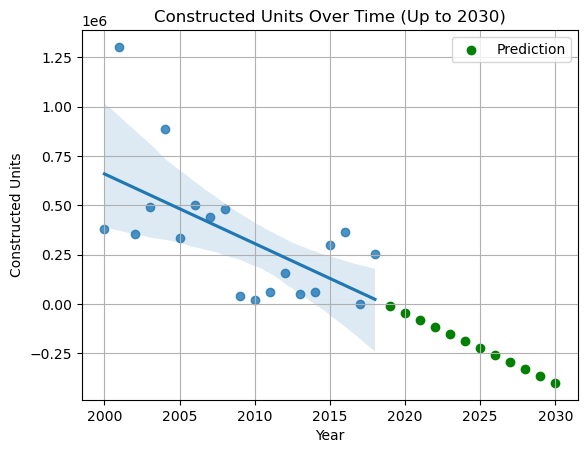

In [210]:
# Linear Regression plot for the number of units constructed annually over time
X_cu, y_cu = create_lr_ttl(bos_df_lst, "Constructed Units")
pred_ttl_plt = plot_lin_reg(X_cu, y_cu, "Constructed Units", desired_yr)

330131.0
[330131.0, 422089.5714285718, 517475.71428571455, 616289.4285714291, 718530.7142857146, 824199.5714285718, 933296.0000000009, 1045820.0000000009, 1161771.5714285728]


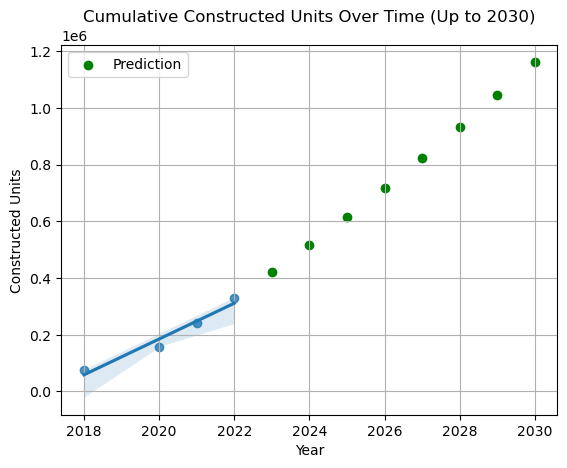

In [211]:
# Linear Regression plot for the cumulative project units in Boston over time 
pred_cumu_plt = plot_cumulative(X_tpu, y_tpu, "Constructed Units", desired_yr)

In [212]:
# Create dictionaries with total, private, and public housing inventories for each year
total_units_dct = {}
private_units_dct = {}
public_units_dct = {}

for i in range(len(YEARS)):
    total_units_dct[YEARS[i]] = get_total_inventory_by_status(year_data[i], neighborhoods)
    private_units_dct[YEARS[i]] = get_total_inventory_by_status(year_data[i], neighborhoods, status = "Private")
    public_units_dct[YEARS[i]] = get_total_inventory_by_status(year_data[i], neighborhoods, status = "Public")

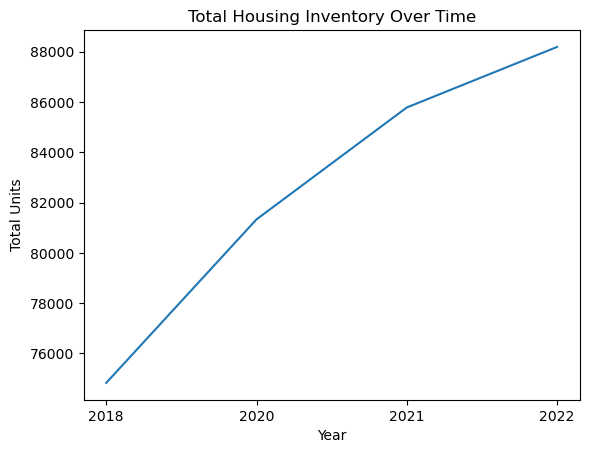

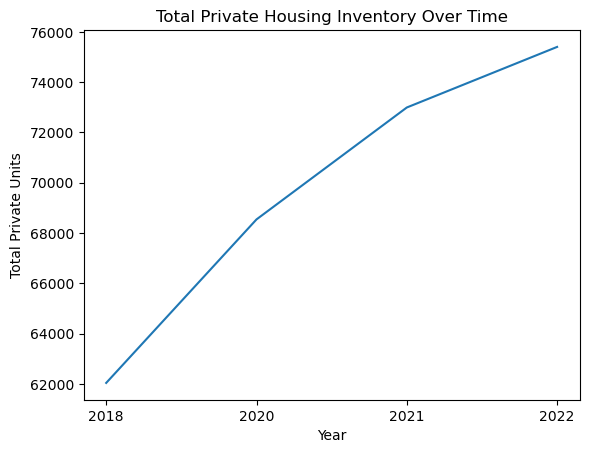

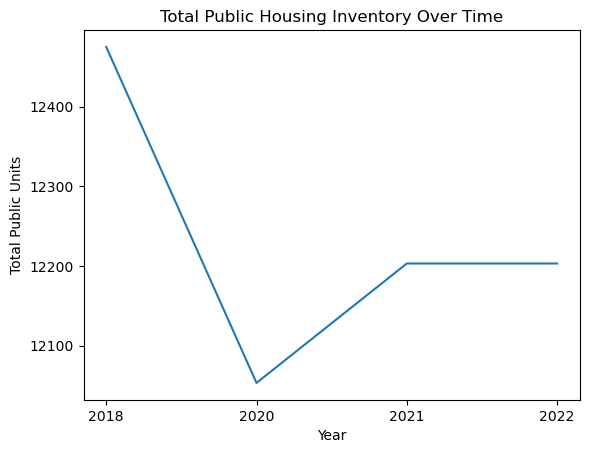

In [213]:
# Plot inventory trends for total, private, and public housing over time
plot_inventory_trends(YEARS, total_units_dct, x_axis = "Year", y_axis = "Total Units", title = "Total Housing Inventory Over Time")
plot_inventory_trends(YEARS, private_units_dct, x_axis = "Year", y_axis = "Total Private Units", 
                      title = "Total Private Housing Inventory Over Time")
plot_inventory_trends(YEARS, public_units_dct, x_axis = "Year", y_axis = "Total Public Units", 
                      title = "Total Public Housing Inventory Over Time")

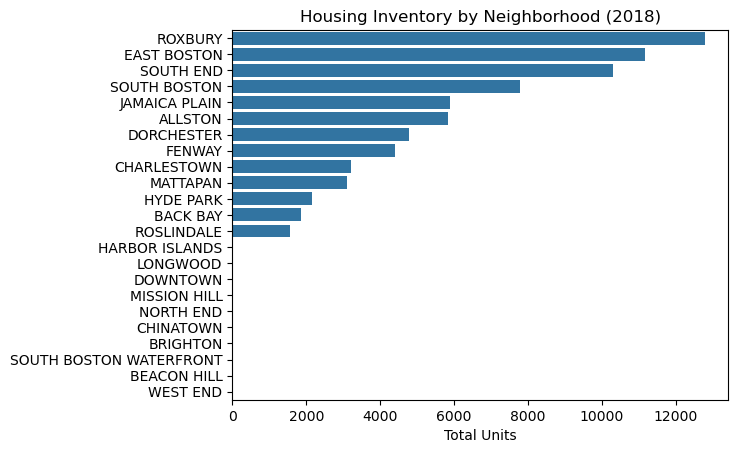

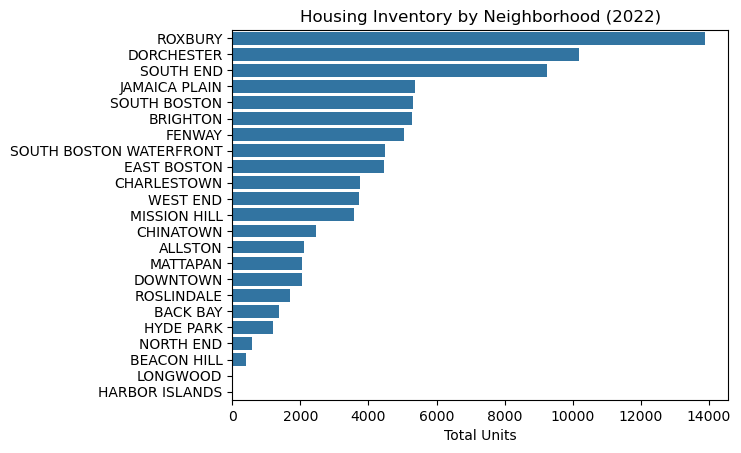

In [214]:
# Plot total general, private, and public housing inventory by neighborhood for 2022
plot_neighborhood_inventory(total_units_dct, "2018", neighborhoods, "Housing Inventory by Neighborhood (2018)", "Total Units")
plot_neighborhood_inventory(total_units_dct, "2022", neighborhoods, "Housing Inventory by Neighborhood (2022)", "Total Units")

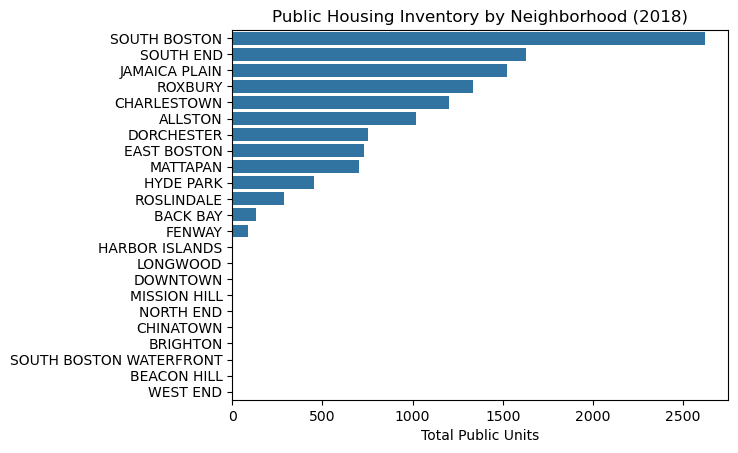

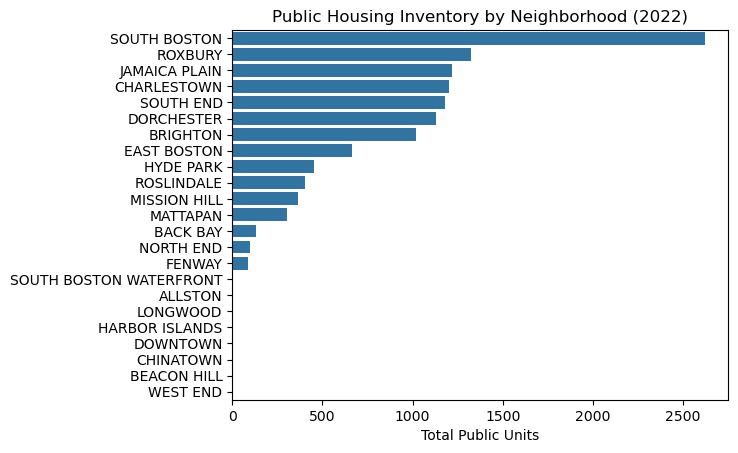

In [215]:
plot_neighborhood_inventory(public_units_dct, "2018", neighborhoods, "Public Housing Inventory by Neighborhood (2018)", "Total Public Units")
plot_neighborhood_inventory(public_units_dct, "2022", neighborhoods, "Public Housing Inventory by Neighborhood (2022)", "Total Public Units")

# Investigating Availability of Income-Restricted Housing By Neighborhood

In [216]:
# Create dictionaries with income-restricted rental & owned inventory by neighborhood and convert to dataframes
rent_dct = {"Neighborhood": neighborhoods}
own_dct = {"Neighborhood": neighborhoods}

for i in range(len(YEARS)):
    rent_dct[YEARS[i]] = get_neighborhood_inventories(year_data[i], neighborhoods, "Income-Restricted Rental")
    own_dct[YEARS[i]] = get_neighborhood_inventories(year_data[i], neighborhoods, "Income-Restricted Ownership")

rent_df = pd.DataFrame(rent_dct)
own_df = pd.DataFrame(own_dct)

In [217]:
# Merge inventory dataframes with geographic dataframe
geo_rent = boston_geo.merge(rent_df, left_on = "neighborho", right_on = "Neighborhood")
geo_own = boston_geo.merge(own_df, left_on = "neighborho", right_on = "Neighborhood")

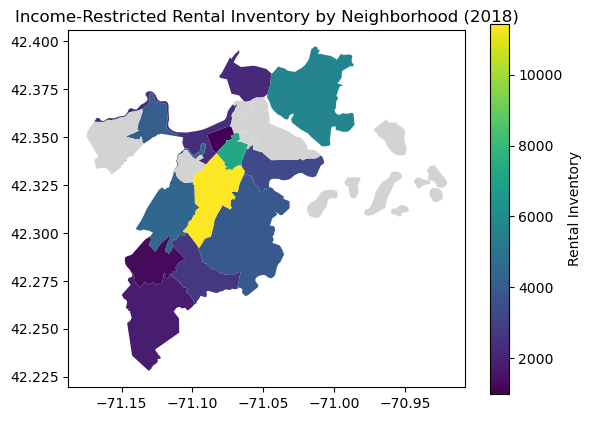

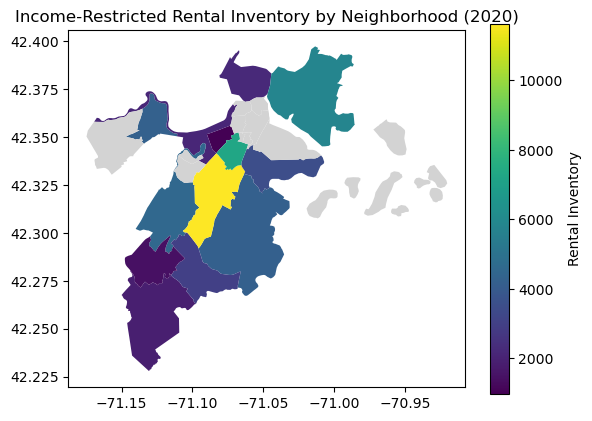

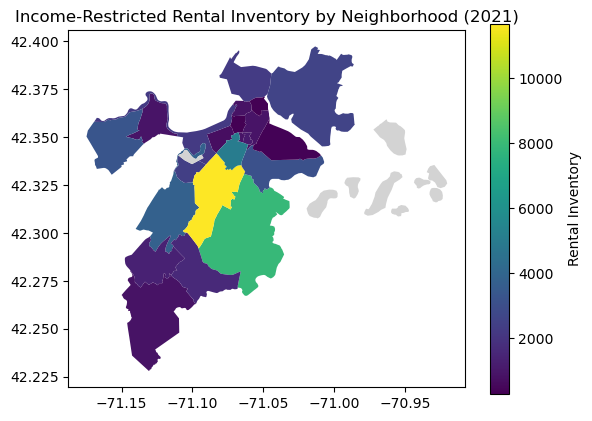

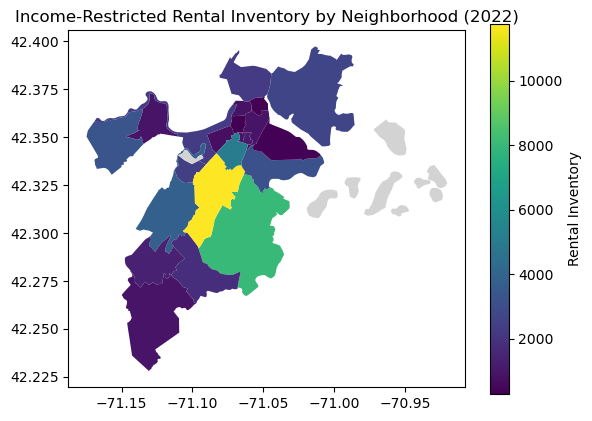

In [218]:
# Plot income-restricted rental inventory by neighborhood for each year
for year in YEARS:
    create_neighborhood_plot(geo_rent, year, "Rental Inventory", f"Income-Restricted Rental Inventory by Neighborhood ({year})")

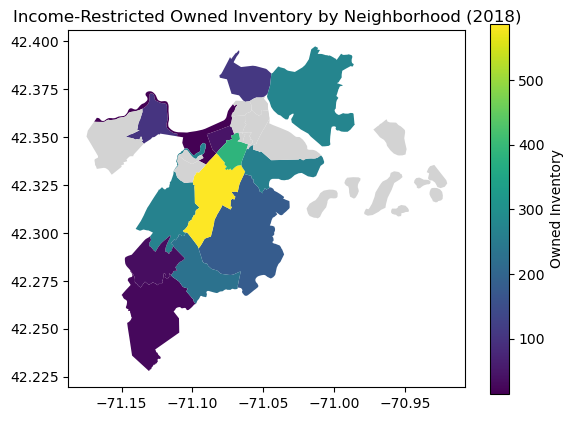

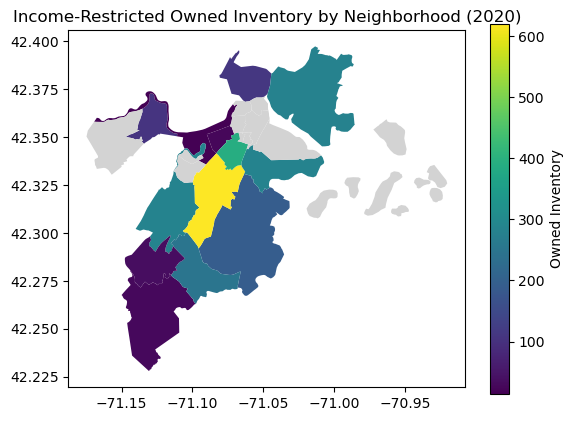

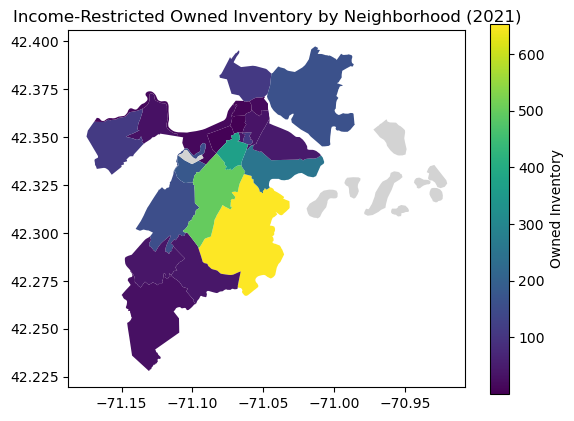

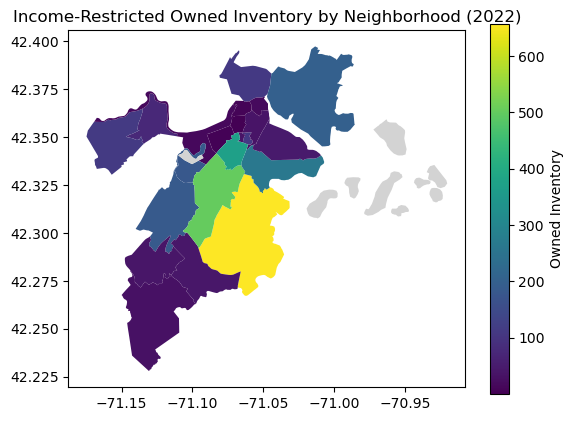

In [219]:
# Plot income-restricted owned inventory by neighborhood for each year
for year in YEARS:
    create_neighborhood_plot(geo_own, year, "Owned Inventory", f"Income-Restricted Owned Inventory by Neighborhood ({year})")

In [220]:
# Create dictionary of income-restricted owned to total income-restricted units for each year and convert to a dataframe
owned_ratio_dct = {"Neighborhood": neighborhoods}

for i in range(len(YEARS)):
    owned_ratio_dct[YEARS[i]] = get_ratio(year_data[i], neighborhoods, "Income-Restricted Ownership", "Total Income-Restricted")

owned_ratio_df = pd.DataFrame(owned_ratio_dct)

In [221]:
# Merge dataframe with ratios with geographic data
geo_owned_ratio = boston_geo.merge(owned_ratio_df, left_on = "neighborho", right_on = "Neighborhood")

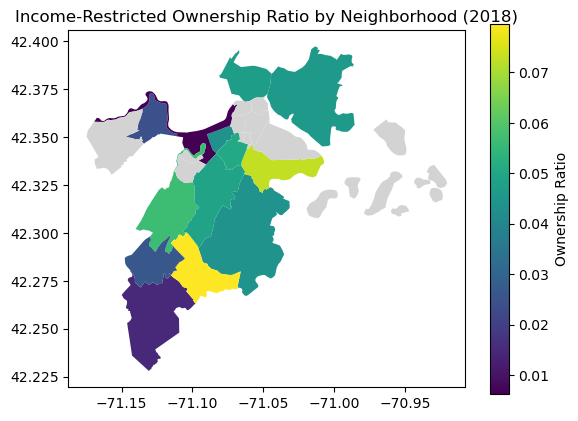

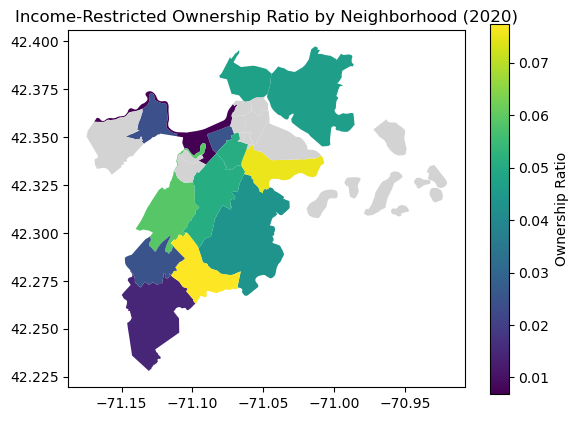

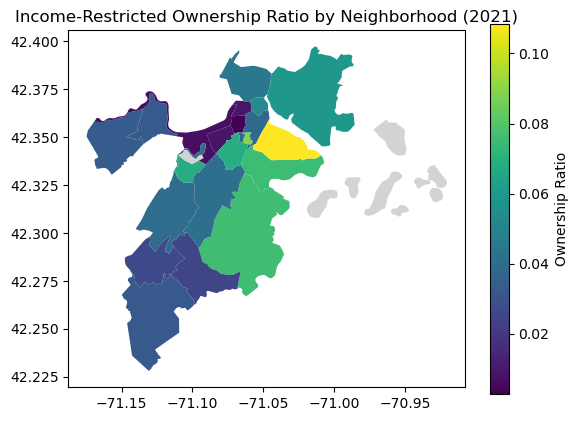

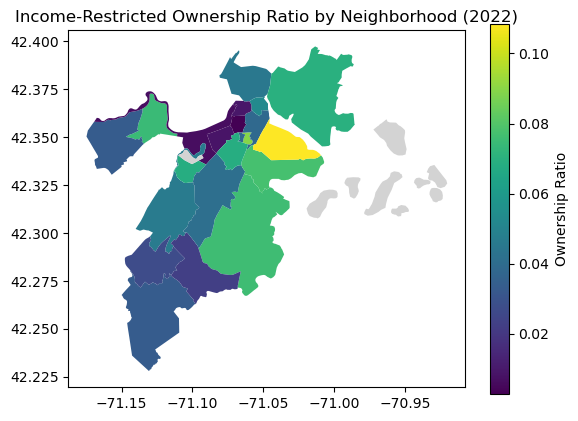

In [222]:
# Plot ratio of income-restricted owned inventory by neighborhood for each year
for year in YEARS:
    create_neighborhood_plot(geo_owned_ratio, year, "Ownership Ratio", f"Income-Restricted Ownership Ratio by Neighborhood ({year})")

# Predicting Overall and Neighborhood Income-Restricted Inventory

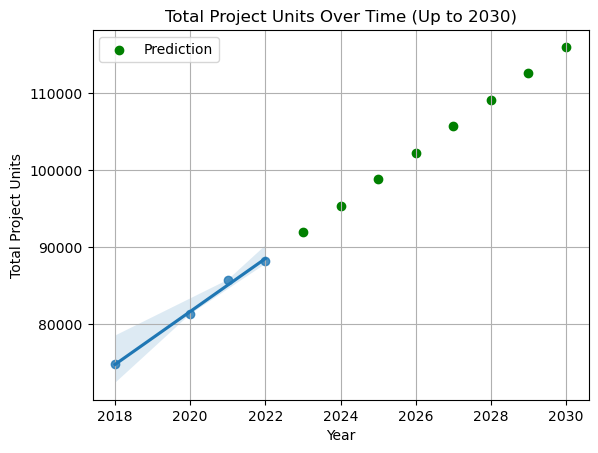

In [223]:
# Linear Regression plot for the total project units over time
X_tpu, y_tpu = create_lr_ttl(year_data, "TtlProjUnits")
pred_ttl_plt = plot_lin_reg(X_tpu, y_tpu, "TtlProjUnits", desired_yr)

In [230]:
# Getting desired neighborhood, column, and year for prediction from user
desired_nb = input("What neighborhood? (all caps)")
desired_col = input("What column?")
desired_yr = input("What year would you like to predict up to?")

What neighborhood? (all caps) ROXBURY
What column? Market Rent
What year would you like to predict up to? 2030


In [ ]:
# Linear Regression plot for total desired column units over time
X_ttl, y_ttl = create_lr_ttl(year_data, desired_col)
pred_ttl_plt = plot_lin_reg(X_ttl, y_ttl, desired_col, desired_yr)

In [ ]:
# Linear Regression plot for desired column over time in desired neighborhood
X_nb, y_nb = create_lr_nb(year_data, desired_col, desired_nb)
pred_nb_plt = plot_lin_reg(X_nb, y_nb, desired_col, desired_yr, desired_nb)